# The Baspa River in the NW Himalaya - LEM from a DEM
**Bodo Bookhagen**

Here we will use a DEM from the Baspa River in the NW Himalaya and perform landscape evolution modeling on it. We rely on the Linear Diffusion and FastScapeEroder. We create a function *load_dem_tif* that allows to directly load a geotiff into a landlab array (gdal is required).

First, let's load the DEM and display it as a landlab grid:

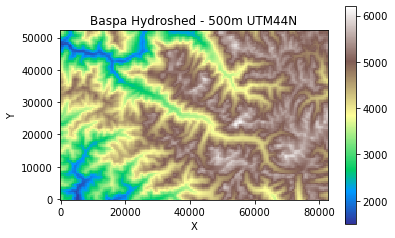

In [1]:
from landlab.io import read_esri_ascii
from landlab.components import LinearDiffuser
from landlab.plot import imshow_grid
from landlab import RasterModelGrid
import matplotlib.pyplot as pl
import numpy as np
from landlab.components import FlowAccumulator, FastscapeEroder, FlowDirectorSteepest
from landlab.components import SinkFiller, SteepnessFinder, ChiFinder, ChannelProfiler
from landlab import load_params
from landlab.components.uniform_precip import PrecipitationDistribution
#from landlab.plot import drainage_plot, channel_profile
from osgeo import gdal, gdalnumeric, ogr, osr

def load_dem_tif(dem_fname):
    """
    Load GeoTIFF with gdal and import into landlab
    """
    t = gdal.Open(dem_fname)
    gt = t.GetGeoTransform()
    cs = t.GetProjection()
    cs_sr = osr.SpatialReference()
    cs_sr.ImportFromWkt(cs)
    #open DEM
    dem = gdalnumeric.LoadFile(dem_fname).astype(float)
    cols = dem.shape[1]
    nr_of_x_cells = cols
    rows = dem.shape[0]
    nr_of_y_cells = rows
    if gt[5] < 0:
        dem = np.flipud(dem)
    idx0 = np.where(dem.ravel() == 0)[0]

    #get UTM coordinates into array:
    ul_x = gt[0]
    ul_y = gt[3]
    utm_x = np.arange(ul_x, ul_x + (gt[1]*(cols+1)), gt[1])
    utm_y = np.arange(ul_y, ul_y + (gt[5]*(rows+1)), gt[5])
    
    mg = RasterModelGrid((rows,cols), abs(gt[1]))
    mg.set_closed_boundaries_at_grid_edges(False, False, False, False)
    _ = mg.add_field('topographic__elevation', dem, at = 'node')
    
    return mg, gt, cs, nr_of_x_cells, nr_of_y_cells, idx0, utm_x, utm_y

baspa_fname = 'Baspa_Hydroshed_500m_UTM44N_WGS84_clip.tif'
mg, gt, cs, nr_of_x_cells, nr_of_y_cells, idx0, utm_x, utm_y = load_dem_tif(baspa_fname)
#Make sure that the imported file doesn't have any NaN/-9999 at its border. 
mg.at_node['topographic__elevation'][mg.at_node['topographic__elevation'] == -9999] = np.min(mg.at_node['topographic__elevation'][mg.at_node['topographic__elevation'] > -9999])
mg.set_closed_boundaries_at_grid_edges(right_is_closed=False, top_is_closed=False, \
                                       left_is_closed=False, bottom_is_closed=False)
z = mg.at_node['topographic__elevation']

pl.figure()
imshow_grid(mg, 'topographic__elevation', 
            plot_name='Baspa Hydroshed - 500m UTM44N', 
            allow_colorbar=True, cmap='terrain', vmin=1500, vmax=6200)

Next, we setup the modeling environment. We run 500 time steps of 1000 y duration (total 500ky) and rely on a rock uplift rate determined by thermochronology (see Thiede ta l., 2005). We plot the output of several components of the modeling runs.

i: 0
i: 50
i: 100
i: 150
i: 200
i: 250
i: 300
i: 350
i: 400
i: 450


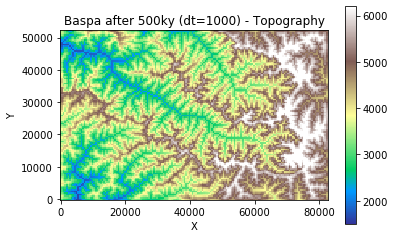

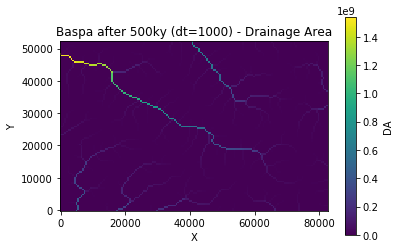

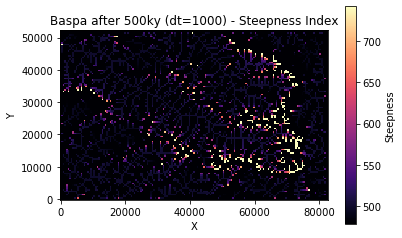

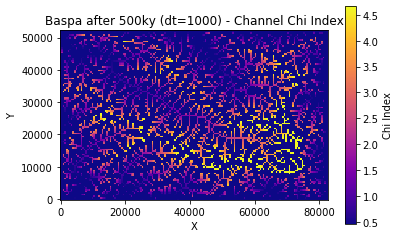

In [2]:
ld = LinearDiffuser(mg, linear_diffusivity=0.001)
fr = FlowAccumulator(mg, flow_director='D8')
fse = FastscapeEroder(mg, K_sp = 1e-5, m_sp=0.5, n_sp=1.)
sf = SinkFiller(mg, routing='D8')

## instantiate helper components
chif = ChiFinder(mg)
steepnessf = SteepnessFinder(mg, reference_concavity=0.5)

## Set some variables
rock_up_rate = 5e-3 #m/yr
dt = 1000 # yr
rock_up_len = dt*rock_up_rate # m
nr_time_steps = 500
## Time loop where evolution happens
for i in range(nr_time_steps):
    z[mg.core_nodes] += rock_up_len #uplift only the core nodes
    ld.run_one_step(dt) #linear diffusion happens.
    sf.run_one_step() #sink filling happens, time step not needed
    fr.run_one_step() #flow routing happens, time step not needed
    fse.run_one_step(dt) #fluvial incision happens
    ## optional print statement
    if np.mod(i,50) == 0:
        print('i:', i)

steepnessf.calculate_steepnesses()  
chif.calculate_chi()
## list the fields that have been created:
mg.at_node.keys()    

pl.figure()
imshow_grid(mg, 'topographic__elevation', 
            plot_name='Baspa after 500ky (dt=1000) - Topography', 
            allow_colorbar=True, cmap='terrain',vmin=1500, vmax=6200)

pl.figure()
imshow_grid(mg, 'drainage_area', 
            plot_name='Baspa after 500ky (dt=1000) - Drainage Area', 
            allow_colorbar=True, colorbar_label='DA', cmap='viridis')

pl.figure()
imshow_grid(mg, 'channel__steepness_index', 
            plot_name='Baspa after 500ky (dt=1000) - Steepness Index', 
            allow_colorbar=True, colorbar_label='Steepness', cmap='magma', 
            vmin=np.percentile(mg.at_node['channel__steepness_index'][mg.at_node['channel__steepness_index'] > 0],5), 
            vmax=np.percentile(mg.at_node['channel__steepness_index'][mg.at_node['channel__steepness_index'] > 0],95) )
            
pl.figure()
imshow_grid(mg, 'channel__chi_index', 
            plot_name='Baspa after 500ky (dt=1000) - Channel Chi Index', 
            allow_colorbar=True, colorbar_label='Chi Index', cmap='plasma', 
            vmin=np.percentile(mg.at_node['channel__chi_index'][mg.at_node['channel__chi_index'] > 0],5), 
            vmax=np.percentile(mg.at_node['channel__chi_index'][mg.at_node['channel__chi_index'] > 0],95) )